In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.io import imread
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


In [2]:
# importing dataset
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


# Extracting only potato dataset

In [3]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [4]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [6]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [7]:
import os

# Paths to your dataset folders
folders = [
    '/kaggle/working/Potato___Late_blight',
    '/kaggle/working/Potato___Early_blight',
    '/kaggle/working/Potato___healthy'
]

# Initialize lists to hold features and labels
X = []  # Feature vectors
y = []  # Corresponding labels

# Iterate over each class folder
for folder in folders:
    label = folder.split('/')[-1]  # Extract class label from folder name
    print(label)
    for filename in os.listdir(folder):
        if filename.endswith(".JPG") or filename.endswith(".PNG"):
            # Full path to image
            file_path = os.path.join(folder, filename)
            

Potato___Late_blight
Potato___Early_blight
Potato___healthy


In [8]:
import os
from skimage.io import imread

# Example path to one image (adjust as necessary)
image_path = os.path.join(folders[0], os.listdir(folders[0])[0])

# Load an image to find its dimensions
image = imread(image_path)

# Calculate the number of features
# If the image is in grayscale, remove the channel dimension in the calculation
if len(image.shape) == 2:
    height, width = image.shape
    num_features = height * width
else:
    height, width, channels = image.shape
    num_features = height * width * channels

print(f"Each image has {num_features} features before any preprocessing.")

Each image has 196608 features before any preprocessing.


In [9]:
import os
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage.io import imread

# Function to compute LBP
def extract_lbp(image, P=8, R=1, method='uniform'):
    """
    Extract Local Binary Pattern (LBP) features from an image.
    
    :param image: Input image.
    :param P: Number of circularly symmetric neighbour set points.
    :param R: Radius of circle.
    :param method: LBP method.
    :return: LBP features.
    """
    image_gray = rgb2gray(image)
    lbp = local_binary_pattern(image_gray, P, R, method)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Function to compute color histogram
def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract color histogram from an image.
    
    :param image: Input image.
    :param bins: Tuple of bins for each channel.
    :return: Color histogram features.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Initialize lists to hold features and labels
X = []  # Feature vectors
y = []  # Corresponding labels

# Iterate over each class folder and extract features
for folder in folders:
    label = folder.split('/')[-1]
    for filename in os.listdir(folder):
        if filename.endswith(".JPG") or filename.endswith(".PNG"):
            file_path = os.path.join(folder, filename)
            image = imread(file_path)
            
            # Extract LBP and color histogram features
            lbp_features = extract_lbp(image)
            color_hist_features = extract_color_histogram(image)
            
            # Combine features and add them to the feature matrix
            combined_features = np.hstack((lbp_features, color_hist_features))
            X.append(combined_features)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

In [10]:
# Display the size of the feature matrix
print(f"Size of the feature matrix (samples, features): {X.shape}")


Size of the feature matrix (samples, features): (2152, 522)


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Encode categorical class labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Mapping of class labels to integer labels:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"'{original}': {encoded}")
# Apply SMOTE to generate synthetic samples and address class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Optional: Convert the resampled labels back to original labels for interpretation
y_resampled_labels = label_encoder.inverse_transform(y_resampled)

# Now, X_resampled and y_resampled contain the features and labels, respectively,
# with the minority class(es) oversampled to address class imbalance.


Mapping of class labels to integer labels:
'Potato___Early_blight': 0
'Potato___Late_blight': 1
'Potato___healthy': 2


In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Assuming y is your array of class labels

# Encode categorical class labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the mapping of original class labels to integer labels
print("Mapping of class labels to integer labels:")
for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"'{original}': {encoded}")

# Print original class distribution
print("\nOriginal class distribution:")
unique, counts = np.unique(y, return_counts=True)
for original, count in zip(unique, counts):
    print(f"{original}: {count}")

# Apply SMOTE to generate synthetic samples and address class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Optional: Convert the resampled labels back to original labels for interpretation
y_resampled_labels = label_encoder.inverse_transform(y_resampled)

# Print resampled class distribution
print("\nResampled class distribution:")
unique_resampled, counts_resampled = np.unique(y_resampled_labels, return_counts=True)
for original, count in zip(unique_resampled, counts_resampled):
    print(f"{original}: {count}")

# Now, X_resampled and y_resampled contain the features and labels, respectively,
# with the minority class(es) oversampled to address class imbalance.


Mapping of class labels to integer labels:
'Potato___Early_blight': 0
'Potato___Late_blight': 1
'Potato___healthy': 2

Original class distribution:
Potato___Early_blight: 1000
Potato___Late_blight: 1000
Potato___healthy: 152

Resampled class distribution:
Potato___Early_blight: 1000
Potato___Late_blight: 1000
Potato___healthy: 1000


In [13]:
print(f"Size of new feature matrix: {X_resampled.shape}")
print(f"Number of samples per class in the resampled dataset:")

# Count the occurrence of each class in the resampled dataset
unique_classes, counts = np.unique(y_resampled_labels, return_counts=True)
for class_name, count in zip(unique_classes, counts):
    print(f"{class_name}: {count}")


Size of new feature matrix: (3000, 522)
Number of samples per class in the resampled dataset:
Potato___Early_blight: 1000
Potato___Late_blight: 1000
Potato___healthy: 1000


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score

# Assuming X_resampled and y_resampled are your features and labels after SMOTE

# Initialize the model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold Cross-Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
cv_results = cross_val_score(random_forest_model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

# Print the results
print(f"CV Accuracy Scores: {cv_results}")
print(f"Mean CV Accuracy: {cv_results.mean()}")
print(f"Standard Deviation of CV Accuracy: {cv_results.std()}")


CV Accuracy Scores: [0.99333333 0.99666667 0.99666667 0.99       0.98333333 0.99666667
 0.99333333 0.99666667 0.99       0.98666667]
Mean CV Accuracy: 0.9923333333333332
Standard Deviation of CV Accuracy: 0.0044845413490245895


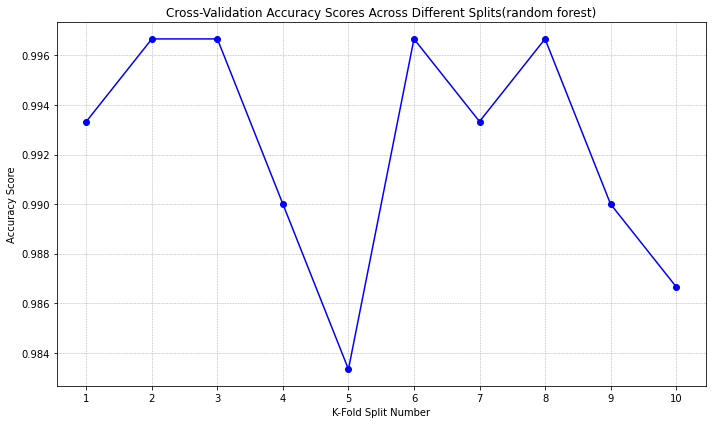

In [15]:
import matplotlib.pyplot as plt

# Assuming cv_results contains the cross-validation accuracy scores from the previous snippet

splits = range(1, 11)  # 10 K-Fold splits
cv_accuracy_scores = cv_results  # Substitute with actual CV accuracy scores if variable not available

plt.figure(figsize=(10, 6))
plt.plot(splits, cv_accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracy Scores Across Different Splits(random forest)')
plt.xlabel('K-Fold Split Number')
plt.ylabel('Accuracy Score')
plt.xticks(splits)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Accuracy for fold 1: 0.9933333333333333
Accuracy for fold 2: 0.9966666666666667
Accuracy for fold 3: 0.9966666666666667
Accuracy for fold 4: 0.99
Accuracy for fold 5: 0.9833333333333333
Accuracy for fold 6: 0.9966666666666667
Accuracy for fold 7: 0.9933333333333333
Accuracy for fold 8: 0.9966666666666667
Accuracy for fold 9: 0.99
Accuracy for fold 10: 0.9866666666666667


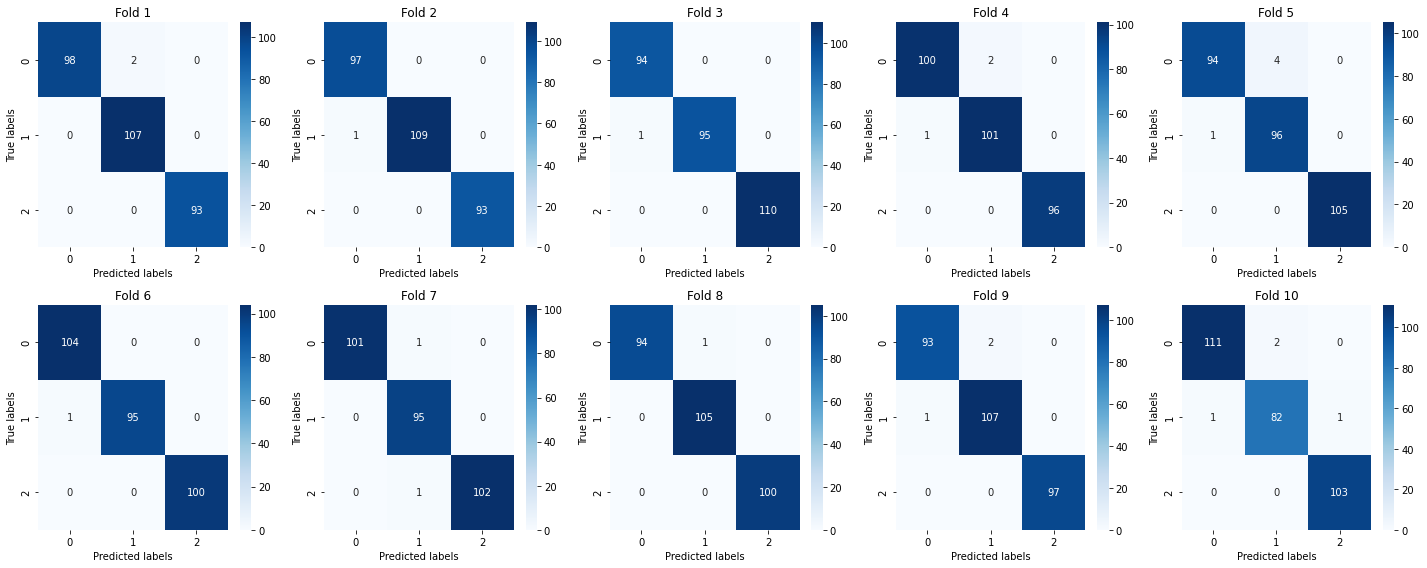

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store results
confusion_matrices = []

# Iterate over each split
fold = 0
for train_index, test_index in kfold.split(X_resampled):
    fold += 1
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    # Train the model
    random_forest_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = random_forest_model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

    # Optionally, print accuracy for the fold
    print(f"Accuracy for fold {fold}: {accuracy_score(y_test, y_pred)}")

# Visualize the confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust subplot layout for 10 folds
axes = axes.flatten()
for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, ax=axes[i], cmap='Blues', fmt='g')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout()
plt.show()


In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

# Assuming X_resampled and y_resampled are your features and labels after SMOTE

# Initialize the model with default parameters
svm_model = SVC(random_state=42)

# Setup K-Fold Cross-Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
cv_results = cross_val_score(svm_model, X_resampled, y_resampled, cv=kfold, scoring='accuracy')

# Print the results
print(f"CV Accuracy Scores: {cv_results}")
print(f"Mean CV Accuracy: {cv_results.mean()}")
print(f"Standard Deviation of CV Accuracy: {cv_results.std()}")


CV Accuracy Scores: [0.98333333 0.97666667 0.98666667 0.99       0.98333333 0.98
 0.99       0.97666667 0.97       0.96333333]
Mean CV Accuracy: 0.9800000000000001
Standard Deviation of CV Accuracy: 0.00816496580927725


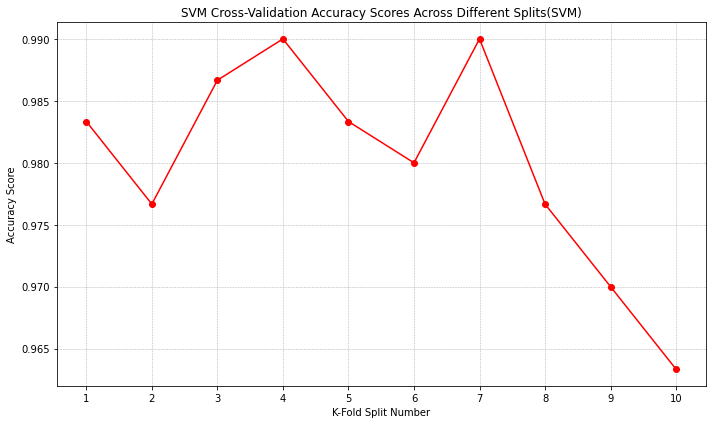

In [18]:
# Assuming cv_results contains the cross-validation accuracy scores from the SVM model

splits = range(1, 11)  # 10 K-Fold splits
cv_accuracy_scores = cv_results  # Use the CV accuracy scores from the SVM model

plt.figure(figsize=(10, 6))
plt.plot(splits, cv_accuracy_scores, marker='o', linestyle='-', color='r')
plt.title('SVM Cross-Validation Accuracy Scores Across Different Splits(SVM)')
plt.xlabel('K-Fold Split Number')
plt.ylabel('Accuracy Score')
plt.xticks(splits)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Accuracy for fold 1: 0.9833333333333333
Accuracy for fold 2: 0.9766666666666667
Accuracy for fold 3: 0.9866666666666667
Accuracy for fold 4: 0.99
Accuracy for fold 5: 0.9833333333333333
Accuracy for fold 6: 0.98
Accuracy for fold 7: 0.99
Accuracy for fold 8: 0.9766666666666667
Accuracy for fold 9: 0.97
Accuracy for fold 10: 0.9633333333333334


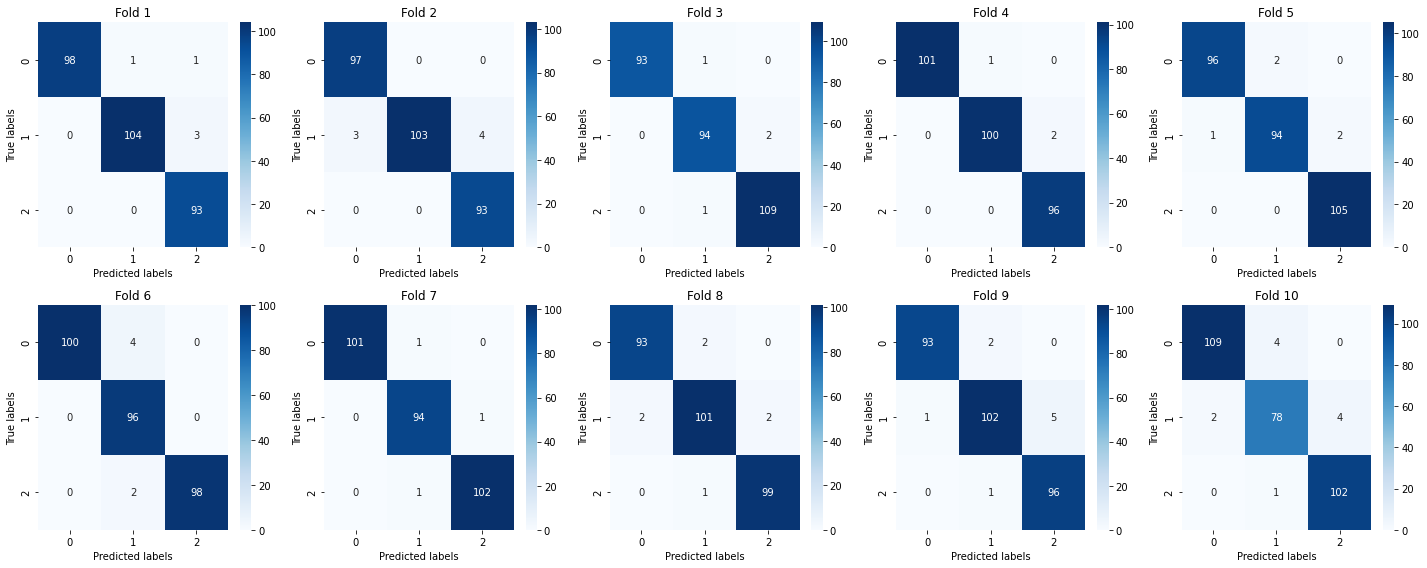

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Setup K-Fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store results
confusion_matrices = []

# Iterate over each split
fold = 0
for train_index, test_index in kfold.split(X_resampled):
    fold += 1
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    # Train the model
    svm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm_model.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

    # Optionally, print accuracy for the fold
    print(f"Accuracy for fold {fold}: {accuracy_score(y_test, y_pred)}")

# Visualize the confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust subplot layout for 10 folds
axes = axes.flatten()
for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, ax=axes[i], cmap='Blues', fmt='g')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout()
plt.show()


In [19]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Encode labels for Stage 1: 0 for Healthy, 1 for Unhealthy (Early_Blight or Late_Blight)
y_stage1 = np.where(y_resampled_labels == 'Potato___healthy', 0, 1)

# Initialize the model for Stage 1
rf_model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold Cross-Validation for Stage 1
kfold_stage1 = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation for Stage 1
cv_results_stage1 = cross_val_score(rf_model_stage1, X_resampled, y_stage1, cv=kfold_stage1, scoring='accuracy')

# Print the results for Stage 1
print(f"Stage 1 - CV Accuracy Scores: {cv_results_stage1}")
print(f"Stage 1 - Mean CV Accuracy: {cv_results_stage1.mean()}")
print(f"Stage 1 - Standard Deviation of CV Accuracy: {cv_results_stage1.std()}")


Stage 1 - CV Accuracy Scores: [1.         1.         1.         1.         1.         1.
 0.99666667 1.         1.         1.        ]
Stage 1 - Mean CV Accuracy: 0.9996666666666666
Stage 1 - Standard Deviation of CV Accuracy: 0.0009999999999999898


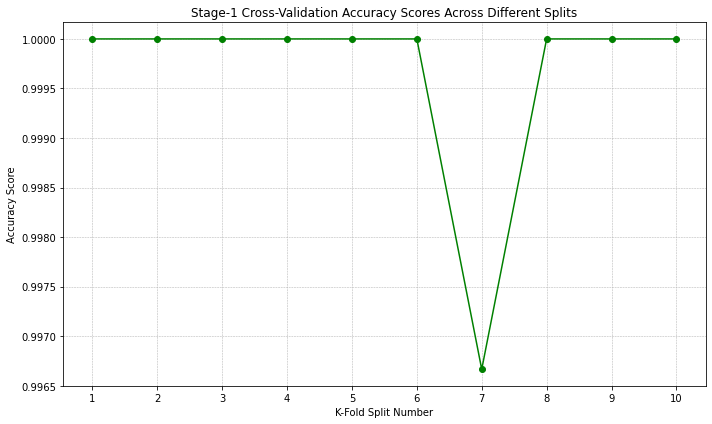

In [20]:
# Assuming cv_results contains the cross-validation accuracy scores from the SVM model

splits = range(1, 11)  # 10 K-Fold splits
cv_accuracy_scores = cv_results_stage1  # Use the CV accuracy scores from the SVM model

plt.figure(figsize=(10, 6))
plt.plot(splits, cv_accuracy_scores, marker='o', linestyle='-', color='g')
plt.title('Stage-1 Cross-Validation Accuracy Scores Across Different Splits')
plt.xlabel('K-Fold Split Number')
plt.ylabel('Accuracy Score')
plt.xticks(splits)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Accuracy for fold 1: 1.0
Accuracy for fold 2: 1.0
Accuracy for fold 3: 1.0
Accuracy for fold 4: 1.0
Accuracy for fold 5: 1.0
Accuracy for fold 6: 1.0
Accuracy for fold 7: 0.9966666666666667
Accuracy for fold 8: 1.0
Accuracy for fold 9: 1.0
Accuracy for fold 10: 1.0


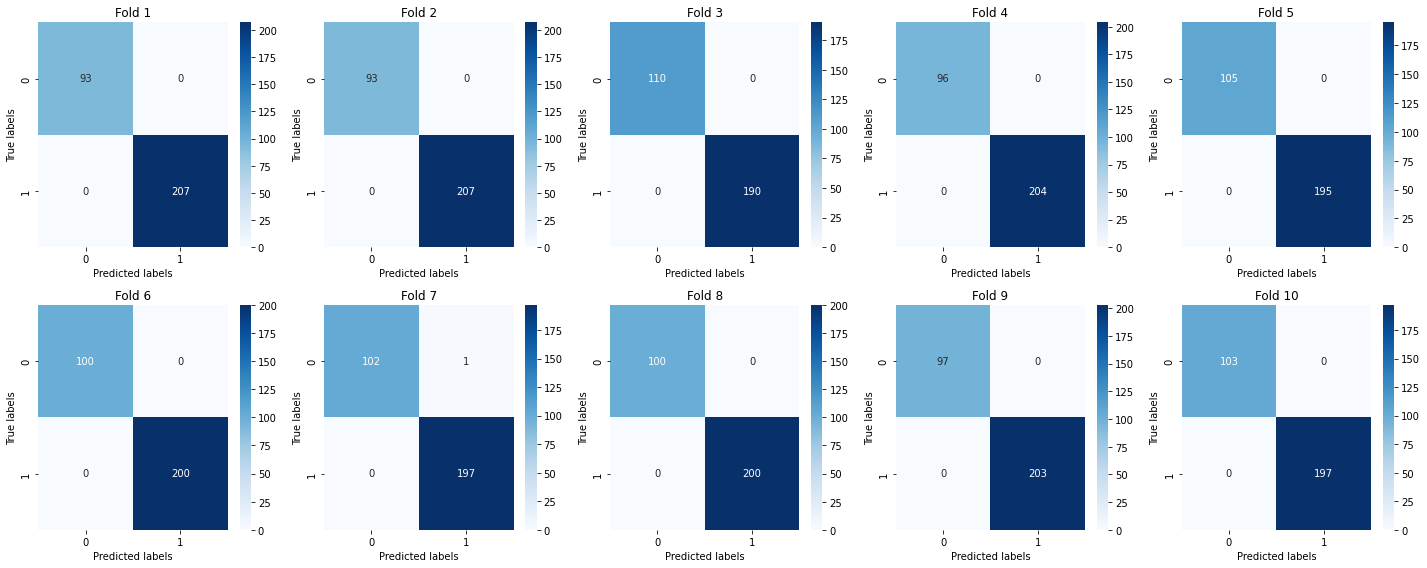

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the RandomForest model
rf_model_stage1 = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold cross-validation
kfold_stage1 = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store results
confusion_matrices_stage1 = []

# Iterate over each split
fold = 0
for train_index, test_index in kfold_stage1.split(X_resampled):
    fold += 1
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_stage1[train_index], y_stage1[test_index]

    # Train the model
    rf_model_stage1.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model_stage1.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices_stage1.append(cm)

    # Optionally, print accuracy for the fold
    print(f"Accuracy for fold {fold}: {accuracy_score(y_test, y_pred)}")

# Visualize the confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust subplot layout for 10 folds
axes = axes.flatten()
for i, cm in enumerate(confusion_matrices_stage1):
    sns.heatmap(cm, annot=True, ax=axes[i], cmap='Blues', fmt='g')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout()
plt.show()


In [21]:
# Filter the dataset for unhealthy samples (Early_Blight and Late_Blight)
unhealthy_mask = y_resampled_labels != 'Potato___healthy'
X_unhealthy = X_resampled[unhealthy_mask]
y_unhealthy = y_resampled_labels[unhealthy_mask]

# Encode labels for Stage 2: 0 for Early_Blight, 1 for Late_Blight
# Assuming 'Potato___Early_blight' is coded as 0 and 'Potato___Late_blight' as 1
y_stage2 = np.where(y_unhealthy == 'Potato___Early_blight', 0, 1)

# Initialize the model for Stage 2
rf_model_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold Cross-Validation for Stage 2
kfold_stage2 = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation for Stage 2
cv_results_stage2 = cross_val_score(rf_model_stage2, X_unhealthy, y_stage2, cv=kfold_stage2, scoring='accuracy')

# Print the results for Stage 2
print(f"Stage 2 - CV Accuracy Scores: {cv_results_stage2}")
print(f"Stage 2 - Mean CV Accuracy: {cv_results_stage2.mean()}")
print(f"Stage 2 - Standard Deviation of CV Accuracy: {cv_results_stage2.std()}")


Stage 2 - CV Accuracy Scores: [0.995 0.99  0.98  0.995 0.985 0.995 0.99  0.995 0.99  0.995]
Stage 2 - Mean CV Accuracy: 0.9909999999999999
Stage 2 - Standard Deviation of CV Accuracy: 0.004898979485566361


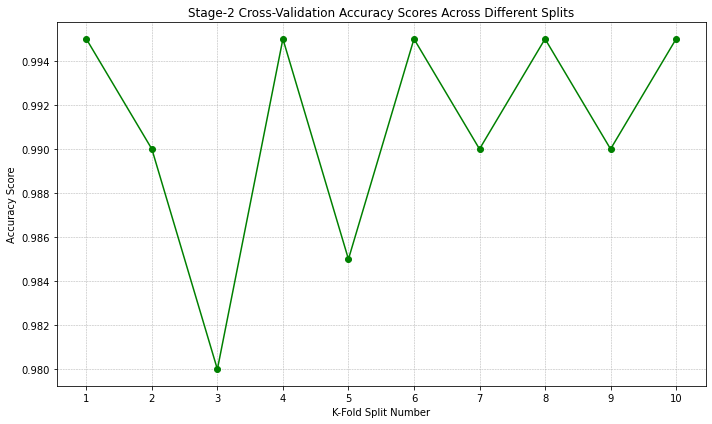

In [22]:
# Assuming cv_results contains the cross-validation accuracy scores from the SVM model

splits = range(1, 11)  # 10 K-Fold splits
cv_accuracy_scores = cv_results_stage2  # Use the CV accuracy scores from the SVM model

plt.figure(figsize=(10, 6))
plt.plot(splits, cv_accuracy_scores, marker='o', linestyle='-', color='g')
plt.title('Stage-2 Cross-Validation Accuracy Scores Across Different Splits')
plt.xlabel('K-Fold Split Number')
plt.ylabel('Accuracy Score')
plt.xticks(splits)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Accuracy for fold 1: 0.995
Accuracy for fold 2: 0.99
Accuracy for fold 3: 0.98
Accuracy for fold 4: 0.995
Accuracy for fold 5: 0.985
Accuracy for fold 6: 0.995
Accuracy for fold 7: 0.99
Accuracy for fold 8: 0.995
Accuracy for fold 9: 0.99
Accuracy for fold 10: 0.995


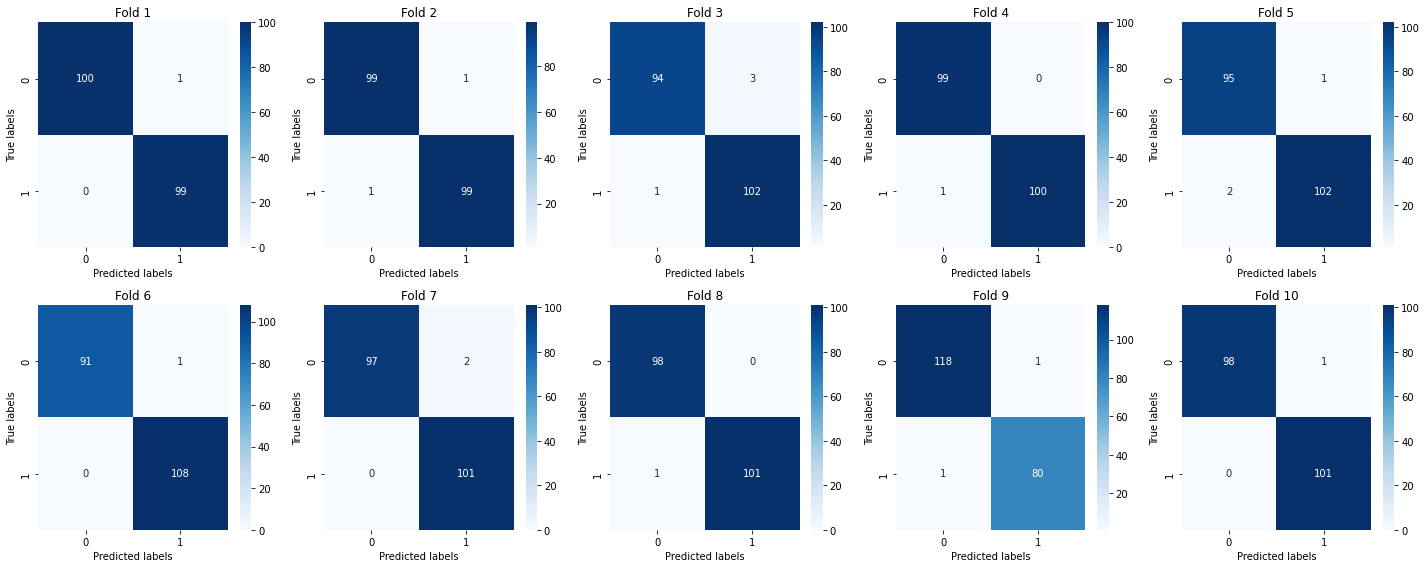

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize the RandomForest model
rf_model_stage2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold cross-validation
kfold_stage2 = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store results
confusion_matrices_stage2 = []

# Iterate over each split
fold = 0
for train_index, test_index in kfold_stage2.split(X_unhealthy):
    fold += 1
    X_train, X_test = X_unhealthy[train_index], X_unhealthy[test_index]
    y_train, y_test = y_stage2[train_index], y_stage2[test_index]

    # Train the model
    rf_model_stage2.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model_stage2.predict(X_test)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices_stage2.append(cm)

    # Optionally, print accuracy for the fold
    print(f"Accuracy for fold {fold}: {accuracy_score(y_test, y_pred)}")

# Visualize the confusion matrices
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust subplot layout for 10 folds
axes = axes.flatten()
for i, cm in enumerate(confusion_matrices_stage2):
    sns.heatmap(cm, annot=True, ax=axes[i], cmap='Blues', fmt='g')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Predicted labels')
    axes[i].set_ylabel('True labels')

plt.tight_layout()
plt.show()
